In [74]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns



import time
from joblib import Memory



In [75]:
DEFAULT_CRS = "EPSG:4326"
RANDOM_STATE = 42

In [76]:
dados = gpd.read_file('data/generate/WGS84_hex_agg_sp_filtred.gpkg')

In [77]:
dados.head()

,id_hex,D1_012_p,D1_017_p,D1_035_p,D1_044_p,qnt_unidades_residencias_sum,qnt_unidades_residencias_mean,qnt_unidades_residencias_median,qnt_unidades_residencias_std,qnt_unidades_residencias_var,...,DCL_stdev,area_sum,area_mean,area_median,area_std,area_var,area_count,area_hex,area_const,geometry
0,8aa8100c3257fff,1.000000,1.000000,1.0,1.000000,111.0,2.084064,0.000000,4.482464,20.092484,...,2.477970,9316.314802,147.878013,90.353599,156.286531,24425.479717,63.0,18002.590726,0.517499,"POLYGON ((-46.63592 -23.53032, -46.63664 -23.5..."
1,8aa8100d2447fff,1.000000,0.989796,1.0,1.000000,108.0,1.374140,0.793144,6.736500,45.380426,...,2.920822,8329.150087,80.865535,61.867680,70.215211,4930.175810,103.0,18009.360752,0.462490,"POLYGON ((-46.53650 -23.53972, -46.53722 -23.5..."
2,8aa8100e1637fff,1.000000,1.000000,1.0,1.000000,95.0,5.270948,0.000035,14.440480,208.527469,...,1.598158,2348.146472,90.313326,71.872491,74.175720,5502.037442,26.0,17997.005022,0.130474,"POLYGON ((-46.66886 -23.59437, -46.66958 -23.5..."
3,8aa8100f0827fff,0.996032,0.992063,1.0,0.996032,0.0,0.000000,0.000000,0.000000,0.000000,...,2.473660,10516.949009,60.442236,46.407855,54.715864,2993.825762,174.0,18001.760632,0.584218,"POLYGON ((-46.59115 -23.61353, -46.59187 -23.6..."
4,8aa81077552ffff,1.000000,0.640000,1.0,1.000000,17.0,0.461107,0.066515,0.586045,0.343448,...,1.824722,8476.202920,180.344743,90.848776,224.256436,50290.949080,47.0,18008.574657,0.470676,"POLYGON ((-46.59688 -23.46650, -46.59760 -23.4..."


In [78]:
col_dic = { 
    "qnt_unidades_residencias_sum": "Soma quantidade de Unidades IPTU", # regularidade fundiária dos
    #"qnt_unidades_residencias_mean": "Média quantidade de Unidades IPTU",
    #"qnt_unidades_residencias_median": "Mediana quantidade de Unidades IPTU",
    #"qnt_unidades_residencias_std": "Desvio Padrão quantidade de Unidades IPTU",
    #"qnt_unidades_residencias_var": "Variância quantidade de Unidades IPTU",
    "esp_1": "Quantidade de Residenciais CNEFE 2022", # regularidade fundiária dos
    #"area_sum": "Soma da área de construção Open Buildings",
    "area_mean": "Média da área de construção Open Buildings", # ambiente construído
    #"area_median": "Mediana da área de construção Open Buildings",
    #"area_var": "Variância Soma da área de construção Open Buildings",
    #"area_std": "Desvio Padrão Soma da área de construção Open Buildings", #ambiente construído
    "area_count": "Quantidade de construção Open Buildings", #ambiente construído
    #"D1_012_d_sum": "Quantidade de domicílios com acesso à rede de água da rede geral CENSO 2010", #infraestrutura urbana
    #"D1_017_d_sum": "Quantidade de domicílios com acesso à rede de esgoto geral CENSO 2010", #infraestrutura urbana
    #"D1_035_d_sum": "Quantidade de domicílios com lixo coletado CENSO 2010", #infraestrutura urbana
    #"D1_044_d_sum": "Quantidade de domicílios com energia elétrica de companhia distribuidora CENSO 2010", #infraestrutura urbana
    "D1_012_p": "Quantidade de domicílios com acesso à rede de água da rede geral CENSO 2010", #infraestrutura urbana
    "D1_017_p": "Quantidade de domicílios com acesso à rede de esgoto geral CENSO 2010", #infraestrutura urbana
    "D1_035_p": "Quantidade de domicílios com lixo coletado CENSO 2010", #infraestrutura urbana
    "D1_044_p": "Quantidade de domicílios com energia elétrica de companhia distribuidora CENSO 2010", #infraestrutura urbana
    "DCL_mean": "Declividade média do terreno em km"

    
}
regul_fun = ["qnt_unidades_residencias_sum", "esp_1"]
#infra_urban_var = ['D1_012_d_sum', "D1_017_d_sum", "D1_035_d_sum", "D1_044_d_sum"]
infra_urban_var = ['D1_012_p', "D1_017_p", "D1_035_p", "D1_044_p"]

ambiente_construído_var = ['area_count', "area_mean"]

In [79]:
df = dados[col_dic.keys()]
y = dados['is_fav_comunidade'].astype(int)

# Analise dos dados indices para identificação de Assentamentos Precários
- Índice de regularidade fundiária dos endereços residenciais
    - CNEFE: Apenas domicílios particulares
    - IPTU: Apenas lançamentos com uso residencial
- Indices de infraestrutura urbana


In [80]:
# Função para aplicar K-means, KMedoids (scikit-learn-extra) com amostragem e mostrar tempo de execução
def compare_clustering_algorithms_with_nmi_and_elbow(data, true_labels, k_range=(2, 10), sample_size=None, if_scaled_data=True):
    # Se uma amostra for especificada, selecioná-la
    if sample_size:
        if isinstance(data, pd.DataFrame):
            data_sampled = data.sample(n=sample_size, random_state=RANDOM_STATE)
            true_labels_sampled = true_labels.loc[data_sampled.index]  # Garantir que os rótulos correspondam aos dados amostrados
        else:
            indices = np.random.choice(data.shape[0], sample_size, replace=False)
            data_sampled = data[indices]
            true_labels_sampled = true_labels[indices]
    else:
        data_sampled = data
        true_labels_sampled = true_labels
    
    
    if if_scaled_data:
        # Padronizar os dados
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data_sampled)
    else:
        scaled_data=data_sampled
    
    # Armazenar os resultados
    silhouette_scores_kmeans = []
    nmi_scores_kmeans = []
    inertia_kmeans = []  # For Elbow method
    
    silhouette_scores_kmedoids_sklearn = []
    nmi_scores_kmedoids_sklearn = []
    inertia_kmedoids_sklearn = []  # Total cost (sum of distances to medoids)
    
    k_values = list(range(k_range[0], k_range[1] + 1))
    
    # Testar diferentes valores de K
    for k in k_values:
        print(f"Processing K={k}...")
        start_time = time.time()
        
        # KMeans
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=RANDOM_STATE, init="random", n_init=1000)
        cluster_labels_kmeans = kmeans.fit_predict(scaled_data)
        silhouette_avg_kmeans = silhouette_score(scaled_data, cluster_labels_kmeans)
        silhouette_scores_kmeans.append(silhouette_avg_kmeans)
        
        # Inertia for KMeans (for Elbow Method)
        inertia_kmeans.append(kmeans.inertia_)
        
        # Normalized Mutual Information for KMeans
        nmi_kmeans = normalized_mutual_info_score(true_labels_sampled, cluster_labels_kmeans)
        nmi_scores_kmeans.append(nmi_kmeans)
        

        '''
        # KMedoids (scikit-learn-extra)
        kmedoids_sklearn = KMedoids(n_clusters=k, random_state=RANDOM_STATE, method="pam")
        cluster_labels_kmedoids_sklearn = kmedoids_sklearn.fit_predict(scaled_data)
        silhouette_avg_kmedoids_sklearn = silhouette_score(scaled_data, cluster_labels_kmedoids_sklearn)
        silhouette_scores_kmedoids_sklearn.append(silhouette_avg_kmedoids_sklearn)
        
        # Total cost (sum of distances to medoids) for Elbow Method (proxy for inertia)
        total_cost_kmedoids = kmedoids_sklearn.inertia_
        inertia_kmedoids_sklearn.append(total_cost_kmedoids)
        
        # Normalized Mutual Information for KMedoids
        nmi_kmedoids_sklearn = normalized_mutual_info_score(true_labels_sampled, cluster_labels_kmedoids_sklearn)
        nmi_scores_kmedoids_sklearn.append(nmi_kmedoids_sklearn)
        '''
        
        # Calcular o tempo de execução
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"K={k} processed in {elapsed_time:.2f} seconds.")
    
    # Plotar o coeficiente de silhueta e Elbow Method para KMeans e KMedoids
    plt.figure(figsize=(14, 10))
    
    # Silhouette Score Plot
    plt.subplot(3, 1, 1)
    plt.plot(k_values, silhouette_scores_kmeans, 'bo-', color='blue', label='KMeans Silhouette Score')
    #plt.plot(k_values, silhouette_scores_kmedoids_sklearn, 'go-', color='green', label='KMedoids Silhouette Score')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Silhouette Coefficient')
    plt.title('Silhouette Coefficient for KMeans and KMedoids (scikit-learn)')
    plt.xticks(k_values)
    plt.grid(True)
    plt.legend()
    
    # NMI Score Plot
    plt.subplot(3, 1, 2)
    plt.plot(k_values, nmi_scores_kmeans, 'bo-', marker='o', label='KMeans NMI Score')
    #plt.plot(k_values, nmi_scores_kmedoids_sklearn, 'go-', marker='s', label='KMedoids NMI Score')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Normalized Mutual Information (NMI)')
    plt.title('NMI for KMeans and KMedoids (scikit-learn)')
    plt.xticks(k_values)
    plt.grid(True)
    plt.legend()
    
    # Elbow Method Plot
    plt.subplot(3, 1, 3)
    plt.plot(k_values, inertia_kmeans, 'bo-', label='KMeans Inertia (Elbow)')
    #plt.plot(k_values, inertia_kmedoids_sklearn, 'go-', label='KMedoids Total Cost (Elbow)')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Inertia / Total Cost')
    plt.title('Elbow Method for KMeans and KMedoids (scikit-learn)')
    plt.xticks(k_values)
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Escolher o melhor valor de K para KMeans e KMedoids
    best_k_kmeans_silhouette = k_values[np.argmax(silhouette_scores_kmeans)]

    #best_k_kmedoids_sklearn = k_values[np.argmax(silhouette_scores_kmedoids_sklearn)]

    
    print(f"Best K for KMeans: {best_k_kmeans_silhouette} with Silhouette Coefficient: {max(silhouette_scores_kmeans)}")
    #print(f"Best K for KMedoids (scikit-learn-extra): {best_k_kmedoids_sklearn} with Silhouette Coefficient: {max(silhouette_scores_kmedoids_sklearn)}")
    
    print(f"Best K for KMeans: {best_k_kmeans_silhouette} with NMI: {max(nmi_scores_kmeans)}")
    #print(f"Best K for KMedoids (scikit-learn-extra): {best_k_kmedoids_sklearn} with NMI: {max(nmi_scores_kmedoids_sklearn)}")
    
    #print(f"Best K for KMeans: {best_k_kmeans_elbow} with Elbow: {max(inertia_kmeans)}")
    #print(f"Best K for KMedoids (scikit-learn-extra): {best_k_kmedoids_sklearn} with Elbow: {max(inertia_kmedoids_sklearn)}")
    
    return {
        'KMeans': {
            'best_k_kmeans_silhouette': best_k_kmeans_silhouette,
            'best_nmi': max(nmi_scores_kmeans),
            'inertia': inertia_kmeans
        }
    }

In [81]:
def best_kmeans(data, best_k, if_scaled_data=True):

    if if_scaled_data:
        # Padronizar os dados
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data)
    else:
        scaled_data=data
    
    # Treinar o KMeans com o melhor K
    best_kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, init="random", n_init=1000)
    #using kmeans because the results are litter better
    best_kmeans.fit(scaled_data)
    
    # Retornar os centróides e rótulos do cluster
    centroids = scaler.inverse_transform(best_kmeans.cluster_centers_) if if_scaled_data else best_kmeans.cluster_centers_ # Desescalonar para os valores originais 
    return centroids, best_kmeans.labels_


## Analise de cluster por Regularidade Fundiária

In [82]:
df.shape

(53559, 9)

Processing K=2...
K=2 processed in 30.72 seconds.
Processing K=3...
K=3 processed in 30.01 seconds.
Processing K=4...
K=4 processed in 34.49 seconds.
Processing K=5...
K=5 processed in 31.79 seconds.
Processing K=6...
K=6 processed in 29.29 seconds.
Processing K=7...
K=7 processed in 27.13 seconds.
Processing K=8...
K=8 processed in 27.24 seconds.
Processing K=9...
K=9 processed in 26.98 seconds.
Processing K=10...
K=10 processed in 26.72 seconds.


/var/folders/kf/12t4yv8j7pg0z8zqbypmj9440000gn/T/ipykernel_75094/2114204425.py:80: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(k_values, silhouette_scores_kmeans, 'bo-', color='blue', label='KMeans Silhouette Score')
/var/folders/kf/12t4yv8j7pg0z8zqbypmj9440000gn/T/ipykernel_75094/2114204425.py:91: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(k_values, nmi_scores_kmeans, 'bo-', marker='o', label='KMeans NMI Score')


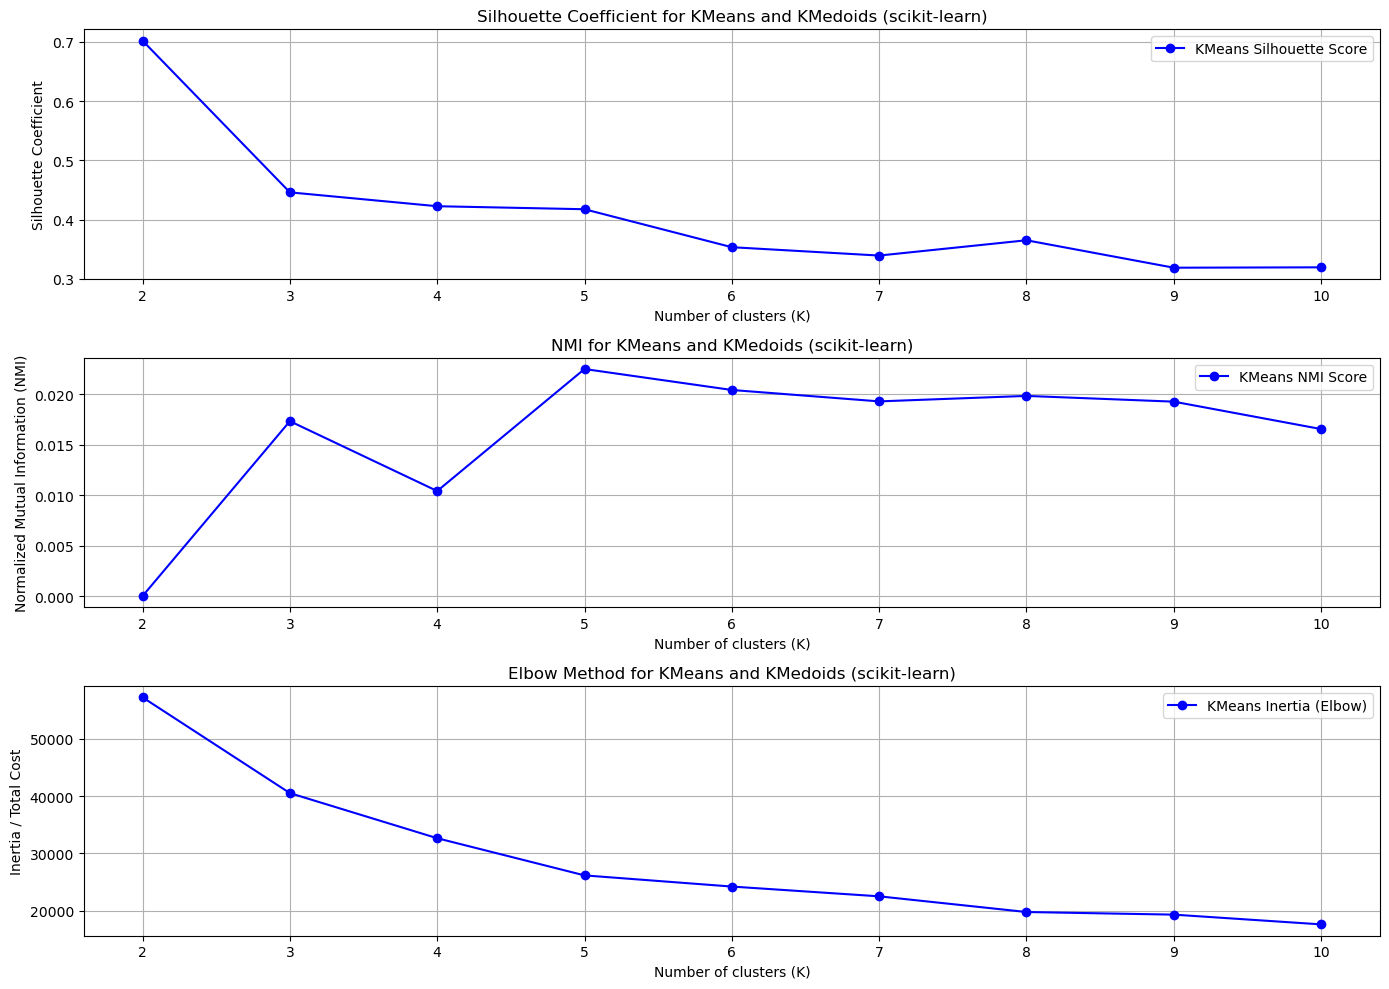

Best K for KMeans: 2 with Silhouette Coefficient: 0.7016974229304209
Best K for KMeans: 2 with NMI: 0.022475776981597716


In [100]:
bests  = compare_clustering_algorithms_with_nmi_and_elbow(df[regul_fun], y, k_range=(2, 10), sample_size=10000)

In [84]:
centroids_regul_fun, labels_regul_fun = best_kmeans(df[regul_fun], 5)

### Visulizar do cluster com melhor métrica

In [87]:
pd.DataFrame(centroids_regul_fun, columns=df[regul_fun].columns)

,qnt_unidades_residencias_sum,esp_1
0,35.883739,242.592318
1,53.857487,103.337410
2,207.742238,189.367238
3,18.972850,30.803906
4,424.956056,407.818864


### Adicionar cluster nos dataframe

In [88]:
dados['cluster_regularidade_fundiaria'] = labels_regul_fun
cluster_regularidade_fundiaria_centroids = centroids_regul_fun

## Analise dos dados indices de infraestrutura urbana
- Dados censitários:
    - percentual de domicílios com acesso à rede de água da rede geral (D1_012)
    - à rede de esgoto geral (D1_017)- 
    - com lixo coletado (D1_035), 
    - com energia elétrica de companhia distribuidora (D1_044))



In [89]:
df[infra_urban_var].head()

,D1_012_p,D1_017_p,D1_035_p,D1_044_p
0,1.000000,1.000000,1.0,1.000000
1,1.000000,0.989796,1.0,1.000000
2,1.000000,1.000000,1.0,1.000000
3,0.996032,0.992063,1.0,0.996032
4,1.000000,0.640000,1.0,1.000000


Processing K=2...
K=2 processed in 3.73 seconds.
Processing K=3...
K=3 processed in 3.55 seconds.
Processing K=4...
K=4 processed in 1.99 seconds.
Processing K=5...
K=5 processed in 1.99 seconds.
Processing K=6...
K=6 processed in 2.07 seconds.
Processing K=7...
K=7 processed in 2.17 seconds.
Processing K=8...
K=8 processed in 2.07 seconds.
Processing K=9...
K=9 processed in 2.07 seconds.
Processing K=10...
K=10 processed in 2.08 seconds.


/var/folders/kf/12t4yv8j7pg0z8zqbypmj9440000gn/T/ipykernel_75094/2114204425.py:80: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(k_values, silhouette_scores_kmeans, 'bo-', color='blue', label='KMeans Silhouette Score')
/var/folders/kf/12t4yv8j7pg0z8zqbypmj9440000gn/T/ipykernel_75094/2114204425.py:91: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(k_values, nmi_scores_kmeans, 'bo-', marker='o', label='KMeans NMI Score')


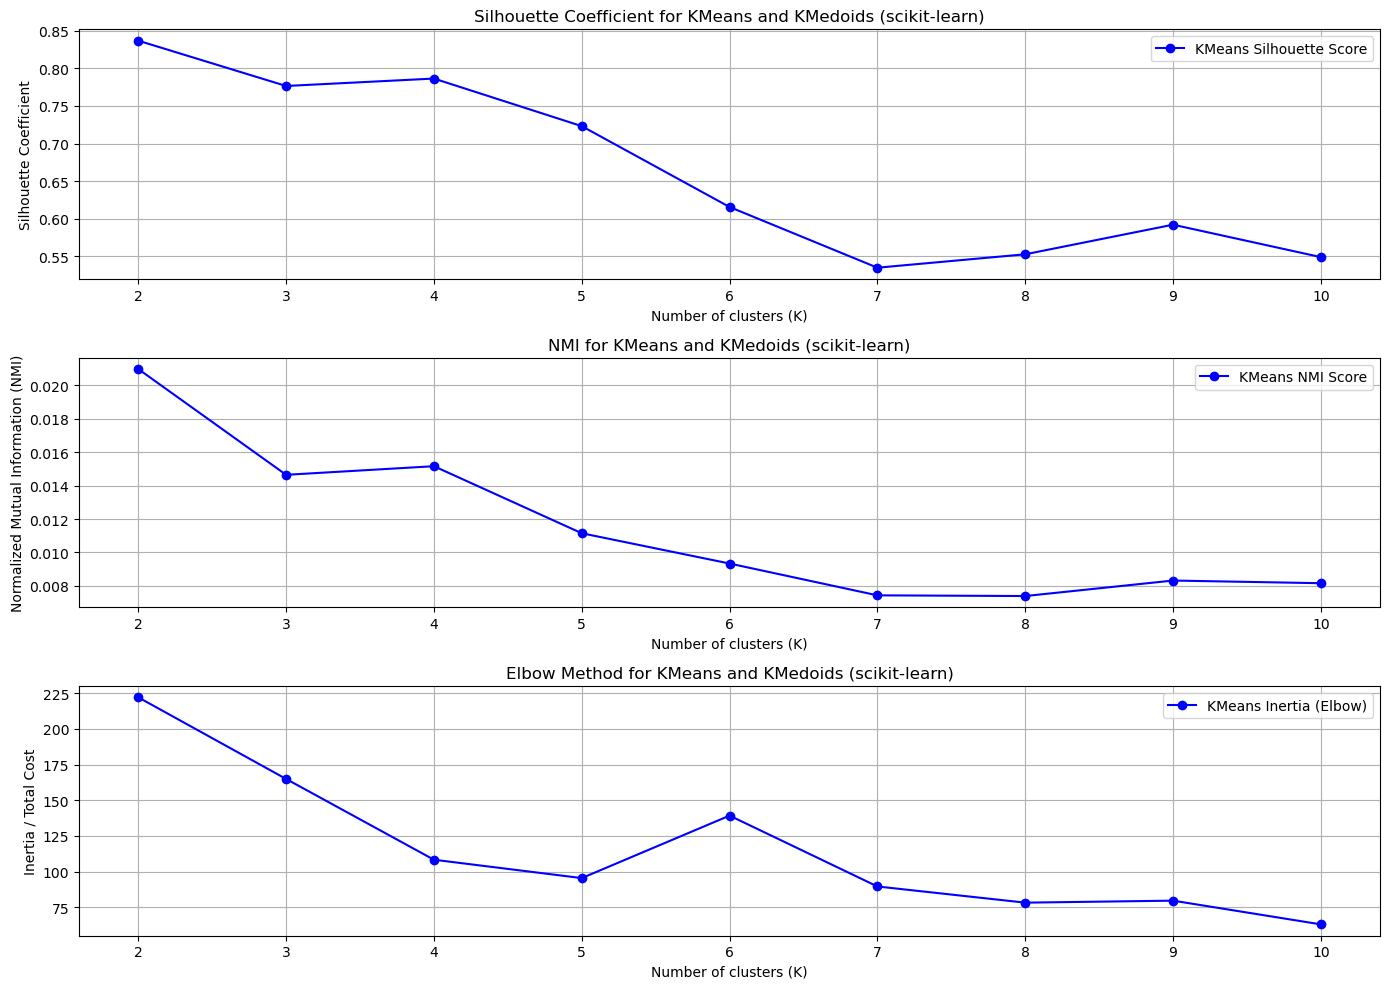

Best K for KMeans: 2 with Silhouette Coefficient: 0.8367184459845667
Best K for KMeans: 2 with NMI: 0.02098689448279015


In [90]:
bests  = compare_clustering_algorithms_with_nmi_and_elbow(df[infra_urban_var], y, k_range=(2, 10), sample_size=10000, if_scaled_data=False)

In [91]:
centroids_infra_urban_var, labels_infra_urban_var = best_kmeans(df[infra_urban_var], 4, if_scaled_data=False)

In [92]:
pd.DataFrame(centroids_infra_urban_var, columns=df[infra_urban_var].columns)

,D1_012_p,D1_017_p,D1_035_p,D1_044_p
0,0.997952,0.980658,0.999167,0.995134
1,0.218238,0.150780,0.827500,0.670883
2,0.976006,0.705804,0.992403,0.967713
3,0.936155,0.273027,0.982940,0.924371


In [93]:
dados['cluster_infraestrutura_urbana'] = labels_infra_urban_var
cluster_infraestrutura_urbana_centroids = centroids_infra_urban_var


## Analise dos dados indices de ambiente construído
- Open Buildings Dataset: 
    - Qnt de construções: area_count
    - Tamanho médio: area_mean
    -- - desvio padrão: area_std--



In [94]:

df[ambiente_construído_var].head()

,area_count,area_mean
0,63.0,147.878013
1,103.0,80.865535
2,26.0,90.313326
3,174.0,60.442236
4,47.0,180.344743


Processing K=2...
K=2 processed in 2.01 seconds.
Processing K=3...
K=3 processed in 2.16 seconds.
Processing K=4...
K=4 processed in 1.92 seconds.
Processing K=5...
K=5 processed in 1.92 seconds.
Processing K=6...
K=6 processed in 1.92 seconds.
Processing K=7...
K=7 processed in 1.96 seconds.
Processing K=8...
K=8 processed in 2.68 seconds.
Processing K=9...
K=9 processed in 2.00 seconds.
Processing K=10...
K=10 processed in 2.02 seconds.


/var/folders/kf/12t4yv8j7pg0z8zqbypmj9440000gn/T/ipykernel_75094/2114204425.py:80: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(k_values, silhouette_scores_kmeans, 'bo-', color='blue', label='KMeans Silhouette Score')
/var/folders/kf/12t4yv8j7pg0z8zqbypmj9440000gn/T/ipykernel_75094/2114204425.py:91: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(k_values, nmi_scores_kmeans, 'bo-', marker='o', label='KMeans NMI Score')


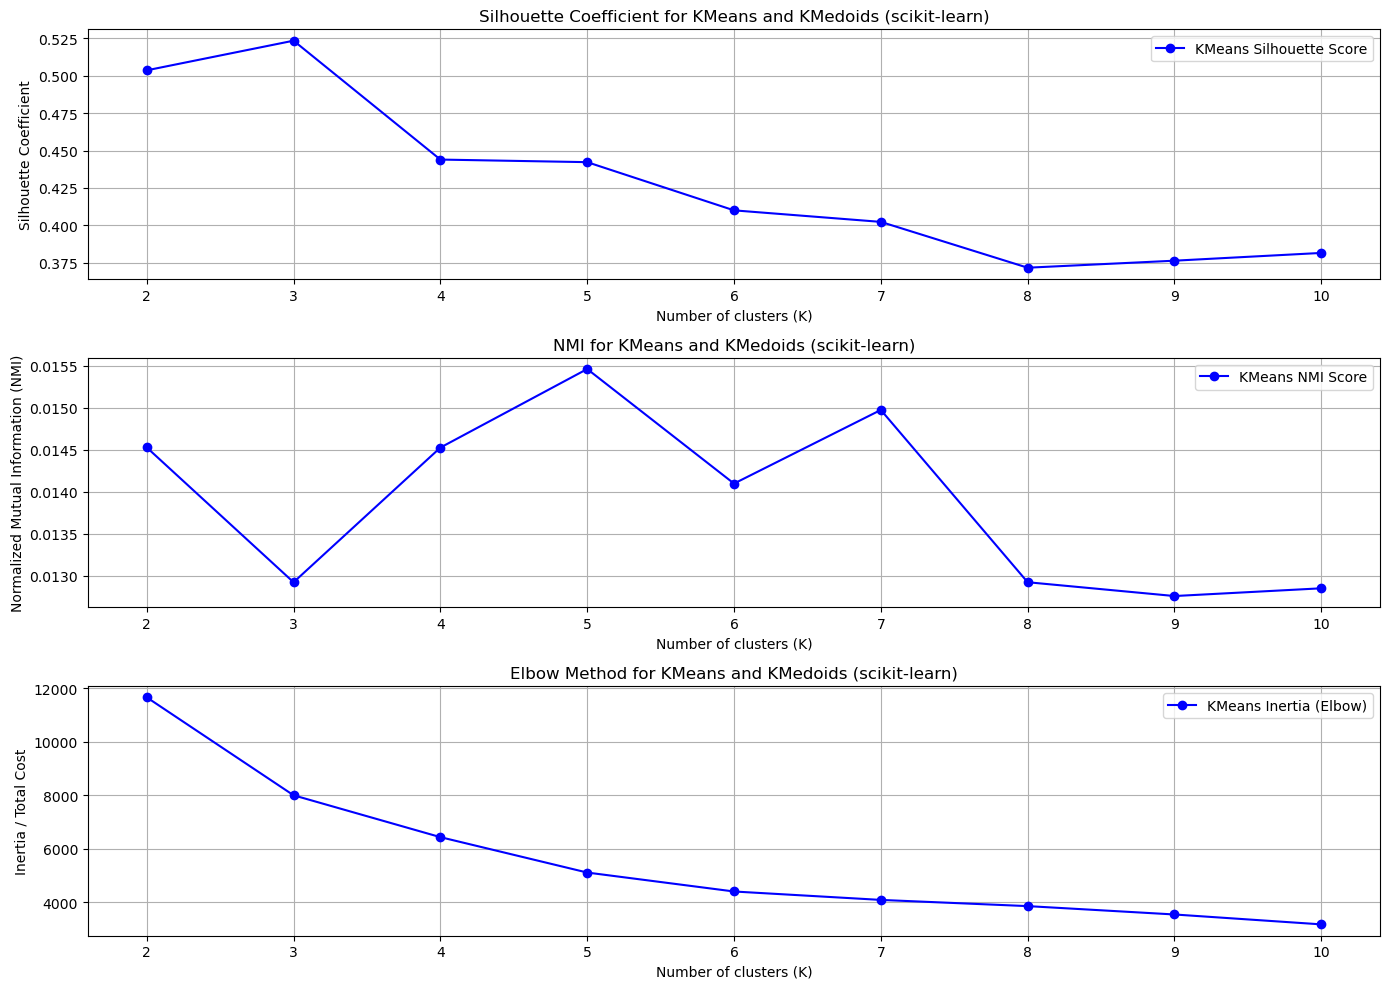

Best K for KMeans: 3 with Silhouette Coefficient: 0.5235056184700093
Best K for KMeans: 3 with NMI: 0.015460864633968258


In [95]:
bests  = compare_clustering_algorithms_with_nmi_and_elbow(df[ambiente_construído_var], y, k_range=(2, 10), sample_size=10000)

In [96]:
centroids_iambiente_construído_var, labels_ambiente_construído_var = best_kmeans(df[ambiente_construído_var], 5)

In [97]:
pd.DataFrame(centroids_iambiente_construído_var, columns=df[ambiente_construído_var].columns)

,area_count,area_mean
0,145.318996,64.491475
1,4.843750,2084.291017
2,18.444444,378.703089
3,37.069173,120.901776
4,90.951000,83.535899


In [98]:
dados['cluster_ambiente_construído'] = labels_ambiente_construído_var
cluster_ambiente_construído_centroids = centroids_iambiente_construído_var


## Geral

Processing K=2...
K=2 processed in 2.28 seconds.
Processing K=3...
K=3 processed in 2.37 seconds.
Processing K=4...
K=4 processed in 2.10 seconds.
Processing K=5...
K=5 processed in 2.06 seconds.
Processing K=6...
K=6 processed in 2.05 seconds.
Processing K=7...
K=7 processed in 2.07 seconds.
Processing K=8...
K=8 processed in 2.06 seconds.
Processing K=9...
K=9 processed in 2.08 seconds.
Processing K=10...
K=10 processed in 2.20 seconds.


/var/folders/kf/12t4yv8j7pg0z8zqbypmj9440000gn/T/ipykernel_75094/2114204425.py:80: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(k_values, silhouette_scores_kmeans, 'bo-', color='blue', label='KMeans Silhouette Score')
/var/folders/kf/12t4yv8j7pg0z8zqbypmj9440000gn/T/ipykernel_75094/2114204425.py:91: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(k_values, nmi_scores_kmeans, 'bo-', marker='o', label='KMeans NMI Score')


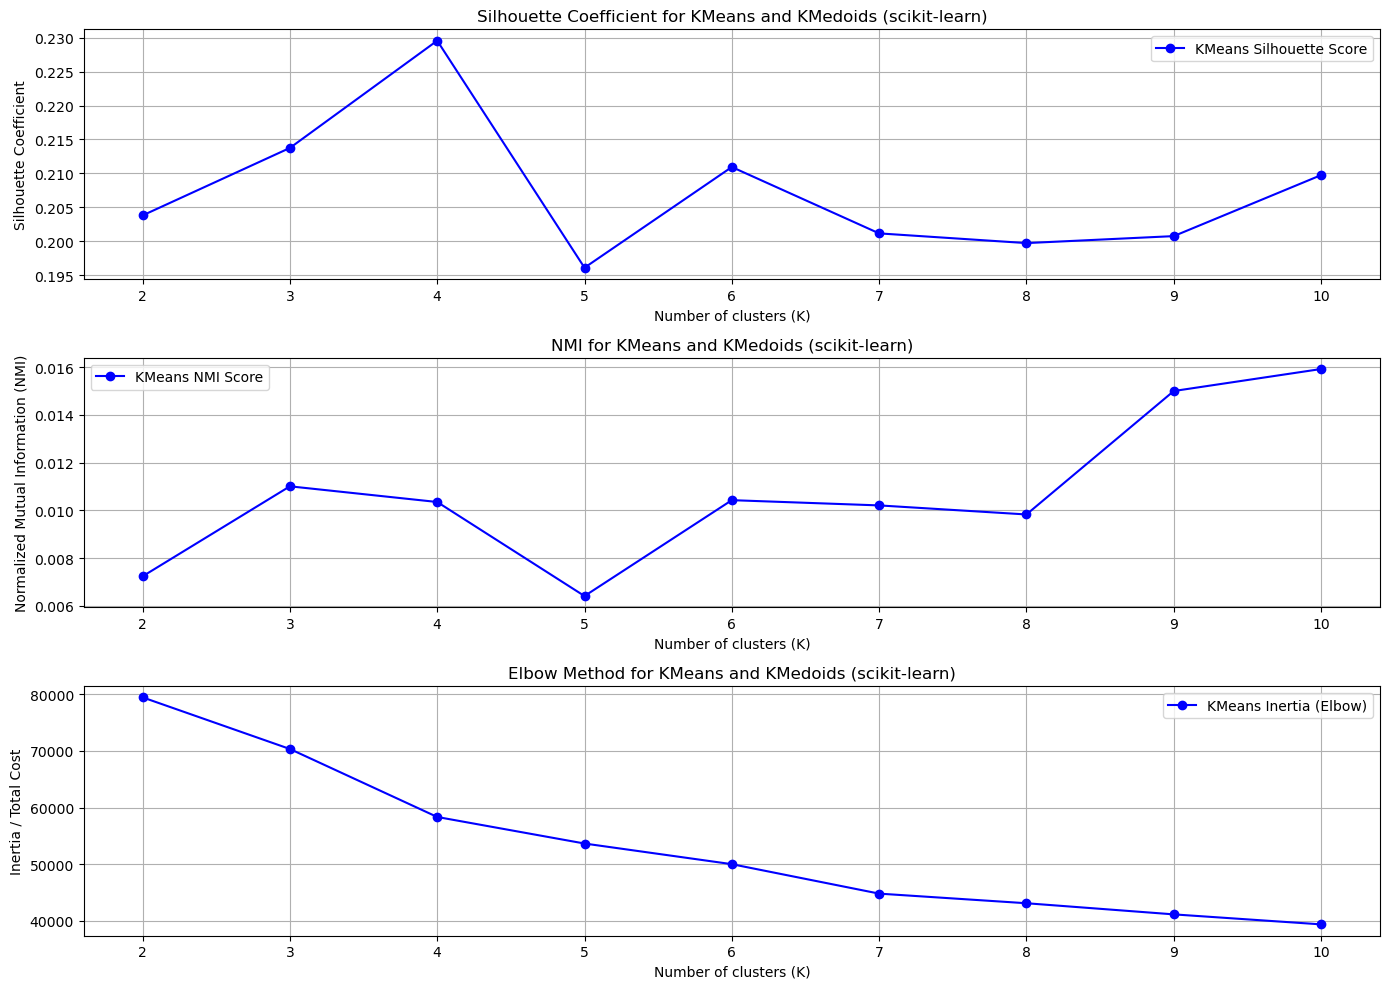

Best K for KMeans: 4 with Silhouette Coefficient: 0.22955469103908044
Best K for KMeans: 4 with NMI: 0.015928292746312345


In [99]:
bests  = compare_clustering_algorithms_with_nmi_and_elbow(df, y, k_range=(2, 10), sample_size=10000)

In [101]:
centroids_geral, labels_geral = best_kmeans(df, 4)

In [102]:
dados['cluster_all'] = labels_geral
cluster_all_centroids = centroids_geral

In [104]:
pd.DataFrame(centroids_geral, columns=df.columns)

,qnt_unidades_residencias_sum,esp_1,area_mean,area_count,D1_012_p,D1_017_p,D1_035_p,D1_044_p,DCL_mean
0,253.896897,270.064678,132.590756,49.376134,0.997667,0.983685,0.999498,0.997171,9.703343
1,48.173220,114.954142,71.690562,124.099097,0.995730,0.911834,0.998089,0.989528,9.272657
2,6.219672,55.624044,80.328684,52.983607,0.378748,0.208695,0.843888,0.648780,10.854875
3,28.373722,39.787699,128.643467,47.600099,0.989687,0.909749,0.997921,0.990151,8.230084


In [105]:
dados_final_df = dados[list(col_dic.keys()) + [column for column in dados.columns if 'cluster' in column] + ['geometry', 'is_fav_comunidade']]

In [106]:
dados_final_df.head()

,qnt_unidades_residencias_sum,esp_1,area_mean,area_count,D1_012_p,D1_017_p,D1_035_p,D1_044_p,DCL_mean,cluster_regularidade_fundiaria,cluster_infraestrutura_urbana,cluster_ambiente_construído,cluster_all,geometry,is_fav_comunidade
0,111.0,114.0,147.878013,63.0,1.000000,1.000000,1.0,1.000000,6.750791,1,0,3,3,"POLYGON ((-46.63592 -23.53032, -46.63664 -23.5...",0
1,108.0,157.0,80.865535,103.0,1.000000,0.989796,1.0,1.000000,10.788276,1,0,4,1,"POLYGON ((-46.53650 -23.53972, -46.53722 -23.5...",0
2,95.0,70.0,90.313326,26.0,1.000000,1.000000,1.0,1.000000,7.683747,1,0,3,3,"POLYGON ((-46.66886 -23.59437, -46.66958 -23.5...",0
3,0.0,471.0,60.442236,174.0,0.996032,0.992063,1.0,0.996032,6.340379,0,0,0,1,"POLYGON ((-46.59115 -23.61353, -46.59187 -23.6...",1
4,17.0,20.0,180.344743,47.0,1.000000,0.640000,1.0,1.000000,4.947622,3,2,3,3,"POLYGON ((-46.59688 -23.46650, -46.59760 -23.4...",0


In [108]:
dados_final_df.to_file("data/generate/clusters.gpkg", driver="GPKG")

In [107]:
# save the dados_final_df to a geojson file
dados_final_df.to_file("data/generate/clusters.geojson", driver="GeoJSON")